# Echo Sequence Prediction

This is the first toy model from Jason Brownlee's [Long Short Term Memory Networks with Python](https://machinelearningmastery.com/lstms-with-python/) book. His book has implementations using Keras. This notebook contains an implementation using Pytorch. From section 6.2 of the book:

>    The echo sequence prediction problem is a contrived problem for demonstrating the memory
capability of the Vanilla LSTM. The task is that, given a sequence of random integers as input, to output the value of a random integer at a specific time input step that is not specified to the model.

>    For example, given the input sequence of random integers [5, 3, 2] and the chosen time
step was the second value, then the expected output is 3. Technically, this is a sequence
classification problem; it is formulated as a many-to-one prediction problem, where there are
multiple input time steps and one output time step at the end of the sequence.

In [1]:
from __future__ import division, print_function
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
%matplotlib inline

In [2]:
DATA_DIR = "../../data"

NUM_CLASSES = 10
SEQUENCE_LENGTH = 5
BATCH_SIZE = 32
NUM_EPOCHS = 20
NUM_SAMPLES = 5000

# train_to_test, train_to_val
DATA_SPLITS = [0.7, 0.9]

EMBED_SIZE = NUM_CLASSES
# will vary from run to run but constant across the run
PREDICT_COL = np.random.randint(SEQUENCE_LENGTH)

MODEL_FILE = os.path.join(DATA_DIR, "torch-06-seq-pred-{:d}.model")
LEARNING_RATE = 1e-2

## Prepare Data

Torch LSTMs expect their data as 3D tensors of shape (SEQUENCE_LENGTH, BATCH_SIZE, EMBEDDING_SIZE), according to [this page](http://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#lstm-s-in-pytorch). We set up our data as an array of shape (SEQUENCE_LENGTH, BATCH_SIZE, NUM_CLASSES). Embedding is 1-hot encoding.

In [3]:
def generate_data(seq_len, num_classes, predict_col, num_samples):
    ohe = OneHotEncoder(n_values=num_classes)
    xs, ys = [], []
    for i in range(num_samples):
        random_seq = np.random.randint(0, num_classes, seq_len)
        xs.append(ohe.fit_transform(random_seq.reshape(-1, 1)).todense())
        ys.append(random_seq[predict_col])
    X = np.array(xs)
    y = np.array(ys)
    return X, y

X, y = generate_data(SEQUENCE_LENGTH, NUM_CLASSES, PREDICT_COL, NUM_SAMPLES)
print(X.shape, y.shape)

(5000, 5, 10) (5000,)


In [4]:
def split_dataset(X, y, data_splits):
    Xtv, Xtest, ytv, ytest = train_test_split(X, y, train_size=data_splits[0], 
                                              random_state=42)
    Xtrain, Xval, ytrain, yval = train_test_split(Xtv, ytv, train_size=data_splits[1], 
                                                  random_state=42)
    return Xtrain, ytrain, Xval, yval, Xtest, ytest
    
Xtrain, ytrain, Xval, yval, Xtest, ytest = split_dataset(X, y, DATA_SPLITS)
print(Xtrain.shape, ytrain.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape)

(3150, 5, 10) (3150,) (350, 5, 10) (350,) (1500, 5, 10) (1500,)


/Users/palsujit/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Define Network

In [5]:
class EchoClassifier(nn.Module):
    """
    Input: one-hot encoding (?, 25, 10)
    LSTM: output dimension (512,), extract context vector
    FCN: output dimension 100, softmax
    """
    
    def __init__(self, seq_len, input_dim, hidden_dim, output_dim):
        super(EchoClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        
        # define layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, 1, 
                            batch_first=True, 
                            dropout=0.2)
        self.fc1 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        if torch.cuda.is_available():
            hidden = (Variable(torch.randn(1, x.size(0), self.hidden_dim).cuda()),
                      Variable(torch.randn(1, x.size(0), self.hidden_dim).cuda()))
        else:
            hidden = (Variable(torch.randn(1, x.size(0), self.hidden_dim)),
                      Variable(torch.randn(1, x.size(0), self.hidden_dim)))

        out, hidden = self.lstm(x, hidden)
        out = self.fc1(out[:, -1, :])
        out = self.softmax(out)
        return out    

In [6]:
model = EchoClassifier(SEQUENCE_LENGTH, EMBED_SIZE, 25, NUM_CLASSES)
if torch.cuda.is_available():
    model.cuda()
    
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Train Network

In [7]:
def compute_accuracy(pred_var, true_var):
    if torch.cuda.is_available():
        ypred = pred_var.cpu().data.numpy()
        ytrue = true_var.cpu().data.numpy()
    else:
        ypred = pred_var.data.numpy()
        ytrue = true_var.data.numpy()
    return accuracy_score(ypred, ytrue)
    
history = []
for epoch in range(NUM_EPOCHS):
    num_batches = Xtrain.shape[0] // BATCH_SIZE
    
    shuffled_indices = np.random.permutation(np.arange(Xtrain.shape[0]))
    train_loss, train_acc = 0., 0.
    for bid in range(num_batches):
        Xbatch_data = Xtrain[shuffled_indices[bid * BATCH_SIZE : (bid+1) * BATCH_SIZE]]
        ybatch_data = ytrain[shuffled_indices[bid * BATCH_SIZE : (bid+1) * BATCH_SIZE]]
        Xbatch = Variable(torch.from_numpy(Xbatch_data).float())
        ybatch = Variable(torch.from_numpy(ybatch_data).long())
        if torch.cuda.is_available():
            Xbatch = Xbatch.cuda()
            ybatch = ybatch.cuda()
            
        # initialize gradients
        optimizer.zero_grad()
        
        # forward
        Ybatch_ = model(Xbatch)
        loss = loss_fn(Ybatch_, ybatch)
        
        # backward
        loss.backward()

        train_loss += loss.data[0]
        
        _, ybatch_ = Ybatch_.max(1)
        train_acc += compute_accuracy(ybatch_, ybatch)
        
        optimizer.step()
        
    # compute training loss and accuracy
    train_loss /= num_batches
    train_acc /= num_batches
    
    # compute validation loss and accuracy
    val_loss, val_acc = 0., 0.
    num_val_batches = Xval.shape[0] // BATCH_SIZE
    for bid in range(num_val_batches):
        # data
        Xbatch_data = Xval[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]
        ybatch_data = yval[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]
        Xbatch = Variable(torch.from_numpy(Xbatch_data).float())
        ybatch = Variable(torch.from_numpy(ybatch_data).long())
        if torch.cuda.is_available():
            Xbatch = Xbatch.cuda()
            ybatch = ybatch.cuda()

        Ybatch_ = model(Xbatch)
        loss = loss_fn(Ybatch_, ybatch)
        val_loss += loss.data[0]

        _, ybatch_ = Ybatch_.max(1)
        val_acc += compute_accuracy(ybatch_, ybatch)
        
    val_loss /= num_val_batches
    val_acc /= num_val_batches
    
    torch.save(model.state_dict(), MODEL_FILE.format(epoch+1))
    print("Epoch {:2d}/{:d}: loss={:.3f}, acc={:.3f}, val_loss={:.3f}, val_acc={:.3f}"
          .format((epoch+1), NUM_EPOCHS, train_loss, train_acc, val_loss, val_acc))
    
    history.append((train_loss, val_loss, train_acc, val_acc))

Epoch  1/20: loss=2.292, acc=0.126, val_loss=2.272, val_acc=0.156
Epoch  2/20: loss=2.206, acc=0.240, val_loss=2.196, val_acc=0.241
Epoch  3/20: loss=2.134, acc=0.322, val_loss=2.156, val_acc=0.294
Epoch  4/20: loss=2.101, acc=0.357, val_loss=2.147, val_acc=0.297
Epoch  5/20: loss=2.080, acc=0.376, val_loss=2.141, val_acc=0.312
Epoch  6/20: loss=2.051, acc=0.405, val_loss=2.041, val_acc=0.416
Epoch  7/20: loss=1.992, acc=0.471, val_loss=2.019, val_acc=0.441
Epoch  8/20: loss=1.966, acc=0.494, val_loss=1.956, val_acc=0.503
Epoch  9/20: loss=1.913, acc=0.547, val_loss=1.919, val_acc=0.541
Epoch 10/20: loss=1.858, acc=0.615, val_loss=1.811, val_acc=0.669
Epoch 11/20: loss=1.803, acc=0.665, val_loss=1.741, val_acc=0.731
Epoch 12/20: loss=1.728, acc=0.752, val_loss=1.654, val_acc=0.831
Epoch 13/20: loss=1.611, acc=0.866, val_loss=1.571, val_acc=0.906
Epoch 14/20: loss=1.571, acc=0.900, val_loss=1.537, val_acc=0.938
Epoch 15/20: loss=1.549, acc=0.920, val_loss=1.526, val_acc=0.941
Epoch 16/2

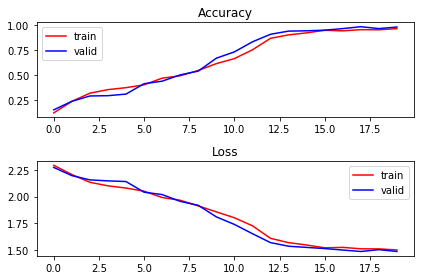

In [8]:
losses = [x[0] for x in history]
val_losses = [x[1] for x in history]
accs = [x[2] for x in history]
val_accs = [x[3] for x in history]

plt.subplot(211)
plt.title("Accuracy")
plt.plot(accs, color="r", label="train")
plt.plot(val_accs, color="b", label="valid")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(losses, color="r", label="train")
plt.plot(val_losses, color="b", label="valid")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Test Network

In [9]:
saved_model = EchoClassifier(SEQUENCE_LENGTH, EMBED_SIZE, 25, NUM_CLASSES)
saved_model.load_state_dict(torch.load(MODEL_FILE.format(10)))
if torch.cuda.is_available():
    saved_model.cuda()

In [10]:
ylabels, ypreds = [], []
num_test_batches = Xtest.shape[0] // BATCH_SIZE
for bid in range(num_test_batches):
    Xbatch_data = Xtest[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]
    ybatch_data = ytest[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]
    Xbatch = Variable(torch.from_numpy(Xbatch_data).float())
    ybatch = Variable(torch.from_numpy(ybatch_data).long())
    if torch.cuda.is_available():
        Xbatch = Xbatch.cuda()
        ybatch = ybatch.cuda()

    Ybatch_ = saved_model(Xbatch)
    _, ybatch_ = Ybatch_.max(1)
    if torch.cuda.is_available():
        ylabels.extend(ybatch.cpu().data.numpy())
        ypreds.extend(ybatch_.cpu().data.numpy())
    else:
        ylabels.extend(ybatch.data.numpy())
        ypreds.extend(ybatch_.data.numpy())

print("Test accuracy: {:.3f}".format(accuracy_score(ylabels, ypreds)))
print("Confusion matrix")
print(confusion_matrix(ylabels, ypreds))

Test accuracy: 0.635
Confusion matrix
[[133   1   0   4   0   1   0   2   3   0]
 [  6 133   6   2   4   5   0   5   2   0]
 [  6  10  70  11   3  16   0   9  23   0]
 [  9   0   0 119   1   1   0   1   5   0]
 [  2   3   1  24 127   1   0   1   0   0]
 [  2   4   3   1   8 122   0   1   9   0]
 [ 12  10  44  10  17  13   0   6  14   0]
 [  4   2   4   7   1   1   0 106   5   0]
 [  6   5   3   6   3  13   0   2 125   0]
 [ 12   5  47  18   7  31   0   4  29   0]]


### Print Random block of test data with labels and predictions

In [11]:
from IPython.core.display import display, HTML

def maybe_highlight(x, j):
    if j == PREDICT_COL:
        return """<span style="background-color:#FFFF00">""" + str(x) + "</span>"
    else:
        return str(x)

start = np.random.randint(Xtest.shape[0] - 10) 
rand_seqs = np.argmax(Xtest[start:start + 10], axis=2)
rand_labels = ylabels[start:start + 10]
rand_preds = ypreds[start:start + 10]

html_str = ""
for i in range(10):
    seq_str = "".join([maybe_highlight(x, j) for j, x in enumerate(rand_seqs[i])])
    html_str += "{:s} {:d} {:d}<br/>".format(seq_str, rand_labels[i], rand_preds[i])
display(HTML(html_str))

In [12]:
for i in range(10):
    os.remove(MODEL_FILE.format(i + 1))